### Analyzing the model velocity data vs. the measured velocity data above the sand bar

Date: 08/01/24

Author: WaveHello

In [24]:
# import default modules
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import pandas as pd
import math
from scipy.interpolate import interp1d

# Set global constants
PI = np.pi

# method to import xbtools with try routine
try:
    import xbTools
except ImportError:
    print('**no xbTools installation found in environment, adding parent path of notebook to see if it works')
    sys.path.append(r"..\..\..\xbeach-toolbox")

In [25]:
from xbTools.xbeachpost import XBeachModelAnalysis
from xbTools.general.executing_runs import generate_batch_script, run_batch_script

In [26]:
# Functions 
def get_script_directory():
    try:
        # This will work if the script is run directly
        script_path = os.path.abspath(__file__)
    except NameError:
        # This will work in an interactive environment like Jupyter
        script_path = os.path.abspath('')
    
    return script_path

def find_closest(array, target):
    # Convert array to a NumPy array if it is not already
    array = np.array(array)
    
    # Compute the absolute differences between each element and the target
    diff = np.abs(array - target)
    
    # Find the index of the minimum difference
    idx = diff.argmin()
    
    # Get the value at that index
    closest_value = array[idx]
    
    return closest_value, idx

def calc_RMSE(observed_vals: np.array, predicted_vals: np.array) -> np.float64:
    """
    Calc the Root Mean squared error for a discrete set of data
    """

    # Check that the observed and the predicted are the same length
    if observed_vals.shape == predicted_vals.shape:
        # Choose one of the arrays since their equal and get the total number of values
        num_vals = observed_vals.size
    else:
        # if the shapes aren't the 
        raise IndexError(f"\nThe shape of observed vals is: {np.shape(observed_vals)}\n"
                         f"The shape of predicted vals is: {np.shape(predicted_vals)}\n")
    
    # Calc the sqaured difference between each term
    abs_diff = (observed_vals - predicted_vals)**2
    
    # Calc the term inside of the square root
    inside   = np.sum(abs_diff) / num_vals 

    # Return the RMSE
    return np.sqrt(inside)

In [27]:
# Import the classes that represent the runs
# Add the library to the path
sys.path.append(r"..\..\..\BarSed_Lib")

# Import the library modules

from lib.data_classes.Run import Run

In [28]:
# Import the raw bathymetry
# Set the important paths
barsed_data_path = r"..\..\..\BarSed_Data"

# Set the information needed for specifying the run
# Run number
run_number = "013"

# Run id
run_id = f"RUN{run_number}"

# Mat file for the first run
run_name = r"{}.mat".format(run_id)

# Adv files information
ADV_data_folder_name = r"ADV"

# Construct the path to the adv data
ADV_folder_path = os.path.join(barsed_data_path, ADV_data_folder_name)

ADV_run_path = os.path.join(ADV_folder_path, run_name)

# Print info
print(f"Run{run_number} ADV mat file path: {ADV_run_path}")


Run013 ADV mat file path: ..\..\..\BarSed_Data\ADV\RUN013.mat


In [29]:
Run_data = Run(id = run_id, wave_file_path=None,
              ADV_file_path = ADV_run_path)

print(Run_data)


id: RUN013
Start Date: None
Wave Data File path: None
Num pressure gagues: None
Num advs: None


In [30]:
Run_data.load_adv_data()

 
# Get the script directory
# Get the folder of the current script
script_dir = get_script_directory()

# Generate the model directory
model_dir = os.path.join(script_dir, f"")


Added: 6 ADV(s)


In [31]:
# Convert the wave maker date_time to time in seconds
first_time = Run_data.ADVs[0].date_time[0]

lab_time = np.array([(dt - first_time).total_seconds() for dt in Run_data.ADVs[0].date_time])


In [32]:
# Store the xbeach data
results = XBeachModelAnalysis(fname = "foo", 
                              model_path=model_dir)

results.load_modeloutput("u")

# Read in the output times from the data and convert from a maked array to regular array
model_time = np.ma.getdata(results.var["globaltime"])
model_xdir = results.var["globalx"][0, :].copy()


loading model output coordinates from file
loading variable u from file


In [33]:
results.load_modeloutput("u")
model_u = results.var["u"]

Variable already loaded


In [34]:
df = pd.read_csv("boun_U.bcf", sep = "\\s+", skiprows=3, header=None, names=["t", "zs", "u"])

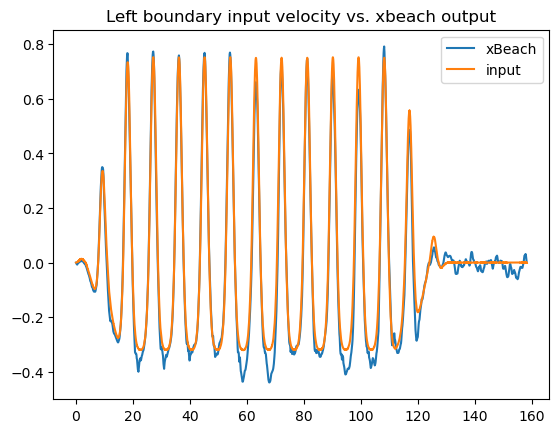

In [35]:
plt.plot(model_time, model_u[:, 0, 0], label = "xBeach")
plt.plot(df["t"], df["u"], label = "input")
plt.title("Left boundary input velocity vs. xbeach output")
plt.legend()
plt.show()

In [36]:
# Info about each of the advs
for adv in Run_data.ADVs:
    print(adv)
    print()

Sensor Name: ADV1 
Sensor id: 1
Flume Height, z (m): 1.567

Sensor Name: ADV2 
Sensor id: 2
Flume Height, z (m): 1.761

Sensor Name: ADV3 
Sensor id: 3
Flume Height, z (m): 1.962

Sensor Name: ADV4 
Sensor id: 4
Flume Height, z (m): 2.162

Sensor Name: ADV5 
Sensor id: 5
Flume Height, z (m): 2.359

Sensor Name: ADV6 
Sensor id: 6
Flume Height, z (m): 2.5599999999999996



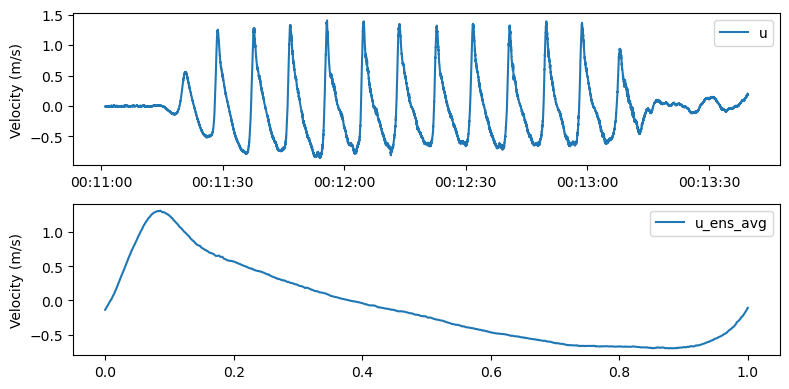

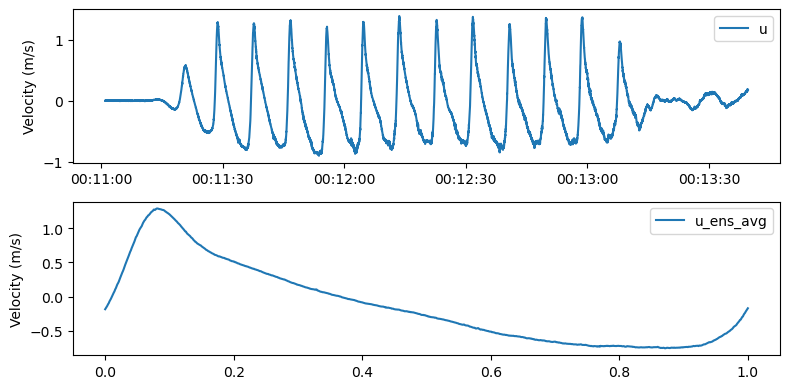

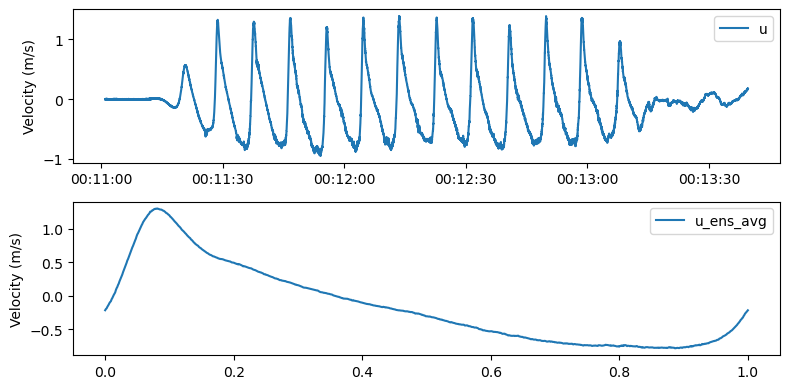

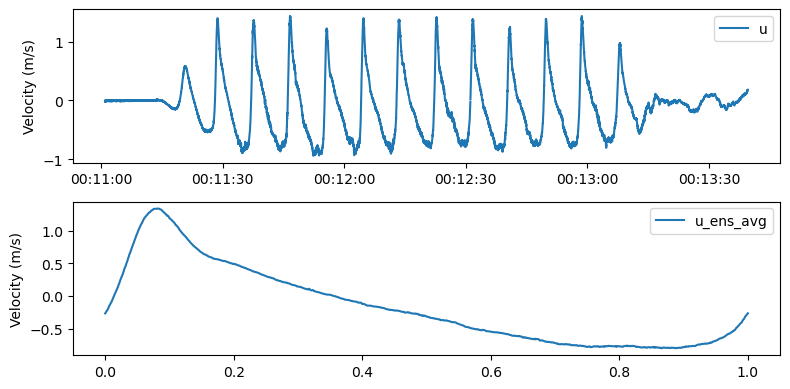

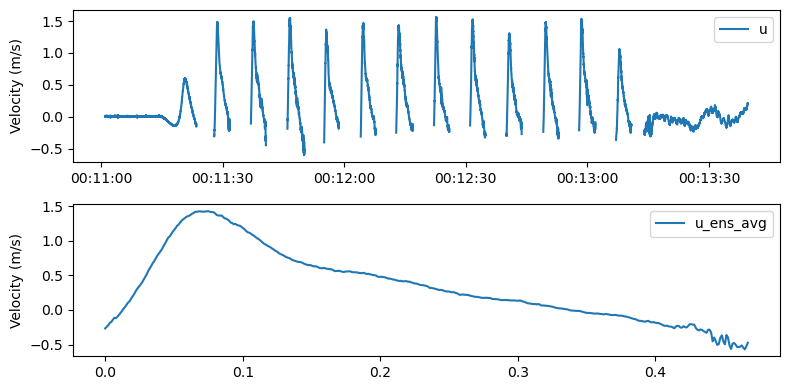

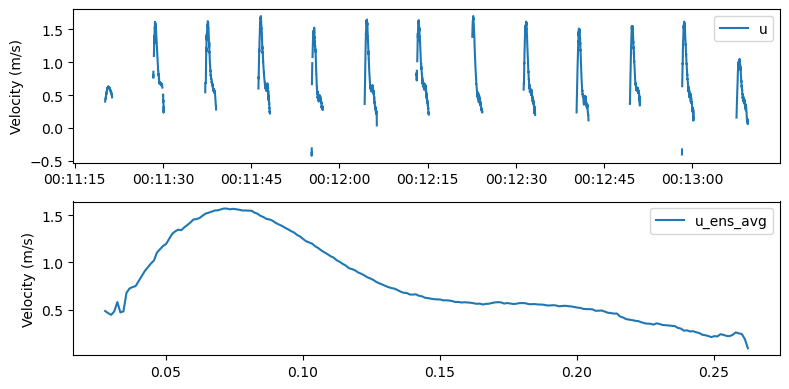

In [37]:
for adv in Run_data.ADVs:
    # Loop over the advs and plot some data

    adv.quick_plot(keys = [ "u", "u_ens_avg"], legend = True, figsize = (8, 4))

### Depth average the lab velocity

In [38]:
# Depth average the velocity
Run_data.ADVs[0].vel["u"]

# Init variable to track the sum of the cleaned velocities
sum_u = 0.0

# Make an array to track how many times each indice is summed with a non-nan value
num_sensors = np.zeros(len(Run_data.ADVs[0].vel["u"]))
# Loop over the advs
for i, adv in enumerate(Run_data.ADVs[:6]):
    # Sum the cleaned velocity
    u = adv.vel["u"]
    
    # Make an array where the values are zero if the value is nan and 1 if it's not nan
    int_mask = np.where(np.isnan(u), 0, 1)

    sum_u += np.nan_to_num(u)
    # Make this an array that keeps track of how many times each element has been summed
    # Some of the values are NaN in the arrays so we need to be able to keep track of each element 
    num_sensors += int_mask

lab_u_avg = sum_u/num_sensors


In [39]:
lab_u_avg

array([-0.00640002, -0.006     , -0.00486666, ...,  0.18835   ,
        0.1844    ,  0.184856  ])

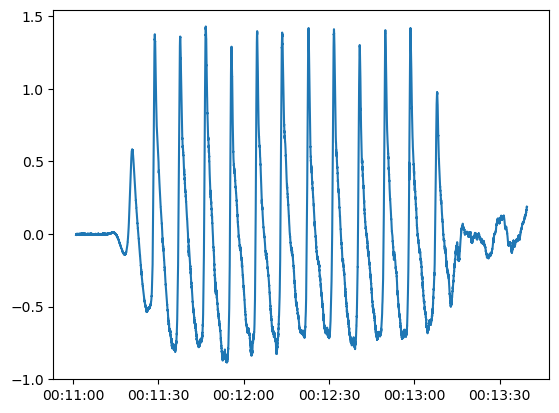

In [40]:
plt.plot(Run_data.ADVs[0].date_time, lab_u_avg)

### Information about the ADV
The location of the ADV array was (45 m, 0.57 m) where the flume centerline (along the x-direction) is y = 0. This information came from page 6 of Mieras et al. Large-scale experimental observations of sheet flo.pdf <br>

**Note**: The ADVs are off center. Just pointing that out so I don't forget. I'm not sure if the measurement is the location of the base of the adv or the actual measuring probe.

In [41]:
# Set the coordinate for the advs
lab_adv_xy_coord = [45, 0.57]

# Find the closest location in the grid to the location of the Advs
closest_loc, xdir_index = find_closest(model_xdir, lab_adv_xy_coord[0])

print(f"The closest location to 45 [m] for this grid is at: {closest_loc} [m]")

The closest location to 45 [m] for this grid is at: 45.198 [m]


In [42]:
model_u[:, 0, xdir_index]

masked_array(data=[0.0, -8.672536348315696e-22, -3.0903069138513014e-21,
                   ..., 0.1530839774913802, 0.15513148796731166,
                   0.15762974216235692],
             mask=[False, False, False, ..., False, False, False],
       fill_value=-3.4028234663852886e+38)

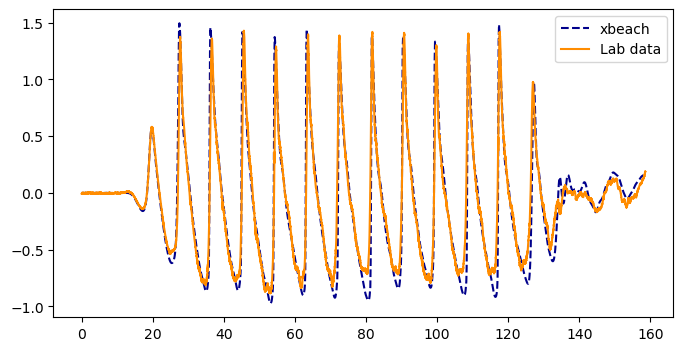

In [43]:
# Plot the xBeach velocity at the closest location

fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 4))

axs = np.atleast_1d(axs)

axs[0].plot(model_time, model_u[:, 0, xdir_index], label = "xbeach",
            color = "darkblue", linestyle = "dashed")
axs[0].plot(lab_time, lab_u_avg, label = "Lab data", 
            color = "darkorange")
plt.legend()
plt.show() 

In [44]:
# Resample the lab data onto the model time.
# There's a lot more lab data than model data for the current time step configuration
lab_u_func = interp1d(lab_time, lab_u_avg)

# Interpolate the model 
resamp_lab_u_avg = lab_u_func(model_time)

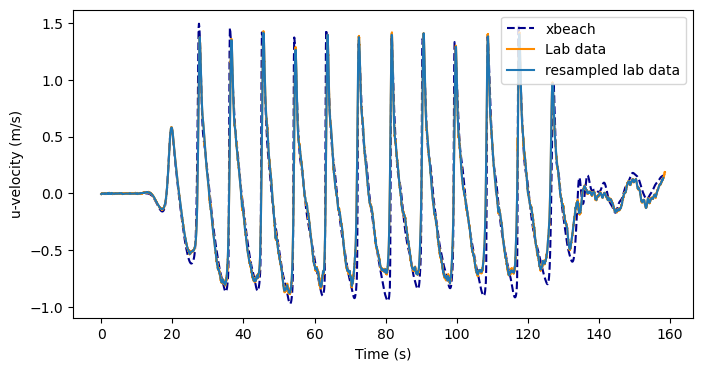

In [45]:
# Plot the xBeach velocity at the closest location

fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 4))

axs = np.atleast_1d(axs)

axs[0].plot(model_time, model_u[:, 0, xdir_index], label = "xbeach",
            color = "darkblue", linestyle = "dashed")

axs[0].plot(lab_time, lab_u_avg, label = "Lab data", 
            color = "darkorange")

axs[0].plot(model_time, resamp_lab_u_avg, label = "resampled lab data")

axs[0].set_ylabel("u-velocity (m/s)")
axs[0].set_xlabel("Time (s)")
plt.legend()
plt.show() 

In [46]:
# Calc the rmse between the reinterpolated velocity
u_avg_RMSE = calc_RMSE(resamp_lab_u_avg, model_u[:, 0, xdir_index])

print(f"u-avg RMSE: {u_avg_RMSE * 100:.2f}%")

u-avg RMSE: 16.04%
